In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict
from scipy.stats import hypergeom

In [2]:
df = []
# Note: Pvactools was not able to complete analysis of samples 69 and 83.
samples = [34,35,39,
           40,41,42,43,44,46,47,48,49,
           50,51,52,53,54,55,56,57,58,59,
           60,61,62,63,64,65,66,68,
           70,71,73,74,75,76,77,78,79,
           80,81,82,84,85,86,88,89,
           91,92]
tag = 'combined'
#tag = 'MHCI'
#tag = 'MHCII'
for sample in samples:
    filename = '../test_samples/pvac/BTN-0{}.filtered.condensed.ranked.tsv'.format(sample)
    #filename = '/home/harald/projects/somatic/test_samples/pvac/BTN-0{}.filtered.condensed.ranked.tsv'.format(sample)
    #filename = '/home/harald/projects/somatic/test_samples/pvacI/BTN-0{}.filtered.condensed.ranked.tsv'.format(sample)
    #filename = '/home/harald/projects/somatic/test_samples/pvacII/BTN-0{}.filtered.condensed.ranked.tsv'.format(sample)
    df.append(pd.read_table(filename, header=0))
for i in range(len(df)):
    df[i]['gene_pos'] = df[i]['Gene Name'] + '_' + df[i]['Protein Position'].astype('str')

In [3]:
# Print a simple report for each sample with the gene and the number of times that gene occur in total.
l = []
for d in df:
    l += list(d['Gene Name'])
all_genes = set(l)
genedb = {}
for gene in all_genes:
    genedb[gene] = l.count(gene)
with open('gene_frequency.{}.txt'.format(tag), 'w') as fout, open('gene_frequency_transposed.{}.txt'.format(tag),'w') as fout2:
    for i,d in enumerate(df):
        fout.write('#S{}\n'.format(samples[i]))
        fout2.write('S{}'.format(i))
        for ind, row in d.iterrows():
            fout.write('{}\t{}\n'.format(row['Gene Name'], genedb[row['Gene Name']]))
            fout2.write('\t{}'.format(genedb[row['Gene Name']]))
        fout2.write('\n')
# Print a simple report for each sample with the gene-pos and the number of times that gene-pos occur in total.
l = []
for d in df:
    l += list(d['gene_pos'])
all_genepos = set(l)
geneposdb = {}
for genepos in all_genepos:
    geneposdb[genepos] = l.count(genepos)
with open('gene-pos_frequency.{}.txt'.format(tag), 'w') as fout, open('gene-pos_frequency_transposed.{}.txt'.format(tag),'w') as fout2:
    for i,d in enumerate(df):
        fout.write('#S{}\n'.format(samples[i]))
        fout2.write('S{}'.format(i))
        for ind, row in d.iterrows():
            fout.write('{}\t{}\n'.format(row['gene_pos'], geneposdb[row['gene_pos']]))
            fout2.write('\t{}'.format(geneposdb[row['gene_pos']]))
        fout2.write('\n')

In [4]:
import re

def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.upper() 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

/home/harald/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


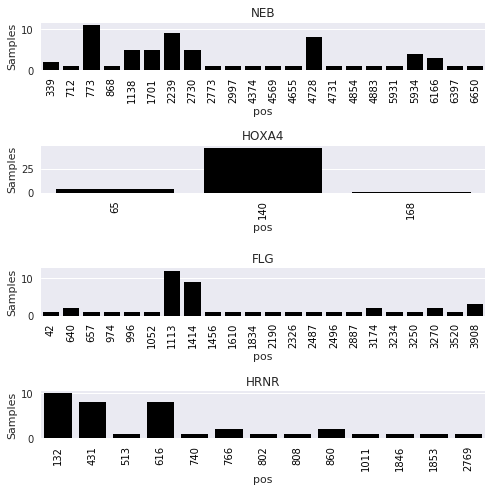

In [5]:
# Make a barplot of how many samples have each mutation
genes = ['NEB','HOXA4','FLG','HRNR']
fig, axes = plt.subplots(len(genes),1,figsize=(7,7))
#plt.xticks(rotation=70)

for i, gene in enumerate(genes):
    a,b,c = [],[],[]
    for genepos,freq in geneposdb.items():
        if gene+'_' not in genepos:
            continue
        t1,t2 = genepos.split('_')
        a.append(t1)
        b.append(int(t2))
        c.append(freq)
    bardf = pd.DataFrame({'gene':a,'pos':b,'samples':c})
    #bardf.columns = ['gene','pos','samples']
    
    sns.barplot(x='pos',y='samples', data=bardf, color='black', ax=axes[i], order=sorted(b))
    axes[i].tick_params(axis='x', labelsize='small', labelcolor='k', labelrotation=90)
    axes[i].set_ylabel('Samples')
    axes[i].set_title(gene)
fig.tight_layout()
fig.savefig('gene_barplot.png')

In [6]:
# Calculate Linked epitopes for epitopes appearing 10 or more times among the samples
l = []
for d in df:
    l += list(d['gene_pos'])
all_genepos = set(l)
geneposdb = {}
for genepos in all_genepos:
    geneposdb[genepos] = l.count(genepos)
linkdb = defaultdict(int)
with open('gene-pos_link-frequency.{}.txt'.format(tag), 'w') as fout:
    fout.write('Epitope1\tEpitope2\tFrequency1\tFrequency2\tLinkFrequency\tp-value\n')
    for i,d in enumerate(df):
        geneposlist = list(d['gene_pos'])
        for i1, genepos1 in enumerate(geneposlist[:-1]):
            if geneposdb[genepos1] < 10:
                continue
            for i2, genepos2 in enumerate(geneposlist[i1+1:]):
                if geneposdb[genepos2] < 10:
                    continue
                a,b = sorted([genepos1,genepos2])
                linkdb[a,b] += 1
    for genepos1,genepos2 in linkdb:
        M = len(df)
        k = linkdb[genepos1,genepos2]
        n = geneposdb[genepos1]
        N = geneposdb[genepos2]
        pval = hypergeom.sf(k-1, M, n, N)
        fout.write('{}\t{}\t{}\t{}\t{}\t{}\n'.format(genepos1,genepos2,n,N,k,pval))


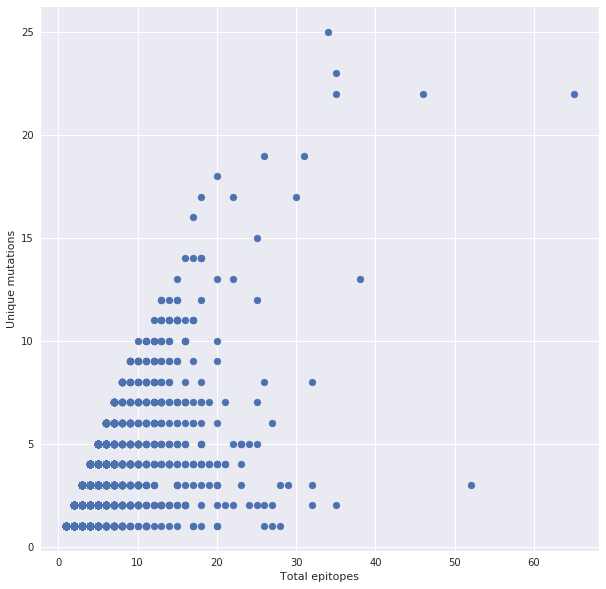

In [7]:
# Report for each gene, how many samples has a mutation at different points
genesummary = {}
for genepos, count2 in geneposdb.items():
    g,pos = genepos.rsplit('_',1)
    if g not in genesummary:
        genesummary[g] = {'pos':[],'counts':[]}
    genesummary[g]['pos'].append(pos)
    genesummary[g]['counts'].append(count2)
x = []
y = []
with open('gene_summary.{}.txt'.format(tag),'w') as fout:
    fout.write('GeneName\tTotalEpitopes\tUniqueMutations\tProteinPositions\n')
    for gene in all_genes:
        x.append(sum(genesummary[gene]['counts']))
        y.append(len(genesummary[gene]['pos']))
        fout.write('{}\t{}\t{}\t{}\n'.format(gene,x[-1],y[-1],';'.join(sorted(genesummary[gene]['pos']))))
fig, axes = plt.subplots(1,1,figsize=(10,10))
axes.scatter(x,y)
axes.set_ylabel('Unique mutations')
axes.set_xlabel('Total epitopes')
fig.savefig('total-epitopes_unique-mutations.{}.png'.format(tag))

In [ ]:
# Plot a histogram of how many epitopes, based on exact same mutation, are shared between any two samples.
shared = []
fig, axes = plt.subplots(1,1,figsize=(10,10))
for i in range(len(df)):
    li = set(list(df[i]['gene_pos']))
    for j in range(len(df)):
        if j <= i:
            continue
        lj = set(list(df[j]['gene_pos']))
        shared.append(len(li.intersection(lj)))
shared = pd.Series(shared)
bins = np.arange(0,50,2)
sns.distplot(shared, kde=False, ax=axes, bins=bins)
fig.savefig('gene-pos_histogram.png')

In [ ]:
# Plot a histogram of how many genes with at least one predicted epitope, not necessarily the same mutation, are shared between any two samples.
shared = []
fig, axes = plt.subplots(1,1,figsize=(10,10))
for i in range(len(df)):
    li = set(list(df[i]['Gene Name']))
    for j in range(len(df)):
        if j <= i:
            continue
        lj = set(list(df[j]['Gene Name']))
        shared.append(len(li.intersection(lj)))
shared = pd.Series(shared)
bins = np.arange(0,100,4)
sns.distplot(shared, kde=False, ax=axes, bins=bins)
fig.savefig('gene_histogram.png')